# Convolutional Neural Networks

TODO: add some exposition.

### Building Our First CNN

Let's use Keras to build a CNN now.

In [22]:
# Setting up MNST, this should look familiar:
import numpy as np
from matplotlib import pyplot as plt
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout
from keras.utils import to_categorical

# For examining results
from sklearn.metrics import confusion_matrix
import seaborn as sn

num_classes = 10 
image_size = 784

(training_images, training_labels), (test_images, test_labels) = fashion_mnist.load_data()
training_data = training_images.reshape(training_images.shape[0], image_size) 
test_data = test_images.reshape(test_images.shape[0], image_size)

training_labels = to_categorical(training_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [3]:
conv_training_data = training_images.reshape(60000, 28, 28, 1)
conv_test_data = test_images.reshape(10000, 28, 28, 1)

In [4]:
def plot_training_history(history, model, eval_images=False):
    figure = plt.figure()

    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.tight_layout()

    figure.tight_layout()
    plt.show()
    
    if eval_images:
        loss, accuracy  = model.evaluate(conv_test_data, test_labels, verbose=False)
    else:
        loss, accuracy  = model.evaluate(test_data, test_labels, verbose=False)
        
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')

This time, we're using a new dataset called "Fashion MNIST". Like the handwritten digits dataset, this is a set of grayscale images each 28 by 28 pixels. However, the subject of these images is very different from the handwritten digits dataset. Instead, these are images of fashion objects. Let's take a look at some:

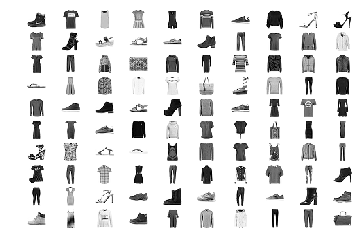

In [50]:
# Lets visualize the first 100 images from the dataset
for i in range(100):
    ax = plt.subplot(10, 10, i+1)
    ax.axis('off')
    plt.imshow(training_images[i], cmap='Greys')

In [15]:
i = 0 # So we can look at one at a time...

# So we can see the label
label_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

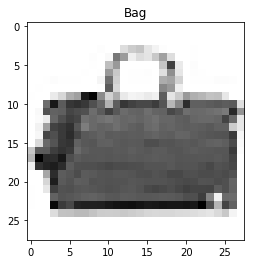

In [51]:
label = np.argmax(training_labels[i])
plt.title(label_map[label])
plt.imshow(training_images[i], cmap='Greys')
i += 1

Once again, there are 10 classes of image:

0 	T-shirt/top  
1 	Trouser  
2 	Pullover  
3 	Dress  
4 	Coat  
5 	Sandal  
6 	Shirt  
7 	Sneaker  
8 	Bag  
9 	Ankle boot  

As you might guess, this is a bigger challenge than the handwritten digits. Firstly, at 28 by 28 pixels much more fidelity is lost in this dataset compared to the digits dataset. Secondly, more pixels matter. In the digits dataset, we rarely care about the weight of the pixel, more or less what matters is if it's white or something else—we mostly cared about the edges between where someone had drawn and where they had not. Now internal differences in grayscale intensity are more informative, and comprise a larger amount of the image.

Let's quickly verify that a standard ANN that worked well in the context of MNIST fails in Fashion MNIST:

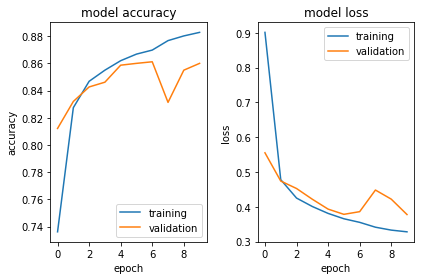

Test loss: 0.405
Test accuracy: 0.854


In [52]:
# Recall from the Optimizers section that we were able to get 97+ test accuracy with this network:
model = Sequential()
model.add(Dense(units=64, activation='relu', input_shape=(image_size,)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))

# nadam performed best, as did categorical cross entropy in our previous experiments...
model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(training_data, training_labels, batch_size=128, epochs=10, verbose=False, validation_split=.1)
plot_training_history(history, model)

Not bad, but not nearly as good as we were able to achieve with regular MNIST. Plus some overfitting concerns are showing themselves in the chart...

In [61]:
# The model is still sequentail, nothing new here.
model = Sequential()

# add model layers. The first parameter is the number of filters to make at each layer.
# Meaning here the result of the first layer is 64 different "feature maps" or "activation maps"
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28,28,1)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

# Lets fit it with identical parameters and see what happens...
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [1]:
# This won't work... why?
history = model.fit(training_data, training_labels, batch_size=128, epochs=20, verbose=True, validation_split=.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/3
54000/54000 [==============================] - 122s 2ms/step - loss: 0.8536 - acc: 0.8323 - val_loss: 0.3396 - val_acc: 0.8768
Epoch 2/3
54000/54000 [==============================] - 122s 2ms/step - loss: 0.2735 - acc: 0.9019 - val_loss: 0.3397 - val_acc: 0.8788
Epoch 3/3
54000/54000 [==============================] - 124s 2ms/step - loss: 0.2211 - acc: 0.9181 - val_loss: 0.3301 - val_acc: 0.8900


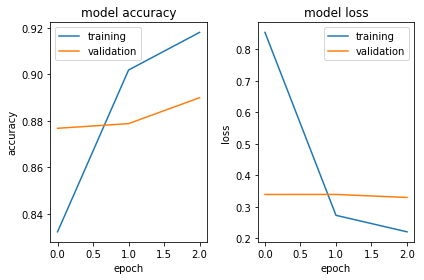

Test loss: 0.356
Test accuracy: 0.884


In [63]:
# OOPS! Previously, we flattened our training data, but now we INTEND on having 2D input data.
# training_data => 784 long vector
# training_images => 28 x 28 matrix
# Plus one small caveat: we have to indicate the number of color channels explicitly as a dimension...
history = model.fit(conv_training_data, training_labels, batch_size=128, epochs=3, verbose=True, validation_split=.1)
plot_training_history(history, model, eval_images=True)

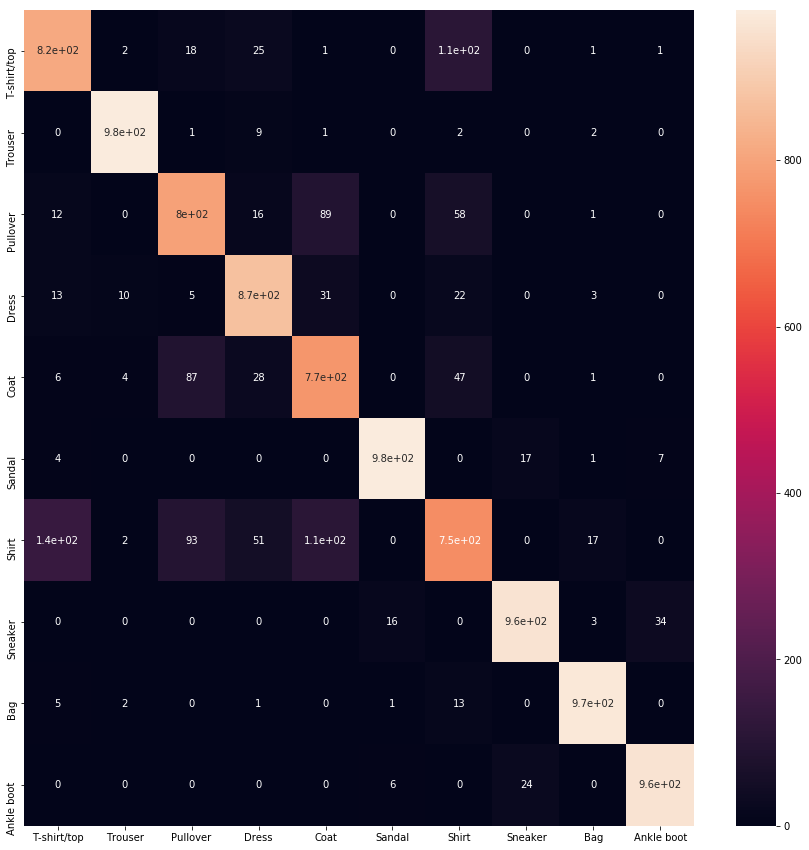

In [81]:
# When did our evaluator do poorly?
predictions = model.predict(conv_test_data)
cm = confusion_matrix(np.argmax(predictions, axis=1), np.argmax(test_labels, axis=1))
plt.figure(figsize = (15, 15))

name_labels = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

sn.heatmap(cm, annot=True, xticklabels=name_labels, yticklabels=name_labels)
plt.show()

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 45s 826us/step - loss: 6.2670 - acc: 0.5408 - val_loss: 0.3794 - val_acc: 0.8622
Epoch 2/5
54000/54000 [==============================] - 40s 744us/step - loss: 0.3540 - acc: 0.8698 - val_loss: 0.3098 - val_acc: 0.8830
Epoch 3/5
54000/54000 [==============================] - 42s 779us/step - loss: 0.2863 - acc: 0.8935 - val_loss: 0.2875 - val_acc: 0.8945
Epoch 4/5
54000/54000 [==============================] - 44s 820us/step - loss: 0.2478 - acc: 0.9076 - val_loss: 0.2787 - val_acc: 0.8997
Epoch 5/5
54000/54000 [==============================] - 43s 795us/step - loss: 0.2230 - acc: 0.9149 - val_loss: 0.2717 - val_acc: 0.9028


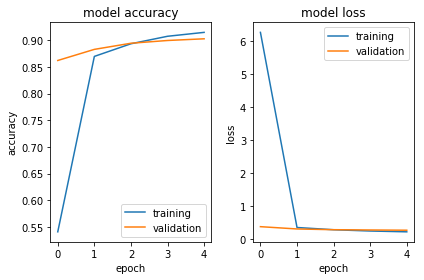

Test loss: 0.297
Test accuracy: 0.896


In [17]:
# Lets make a few small changes and see what happens...
model = Sequential()

# Note, fewer filters and a bigger kernel, plus a pooling layer
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Note, more filters and a pooling
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2 dense layers with dropout before the final.
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(conv_training_data, training_labels, batch_size=128, epochs=5, verbose=True, validation_split=.1)

plot_training_history(history, model, eval_images=True)

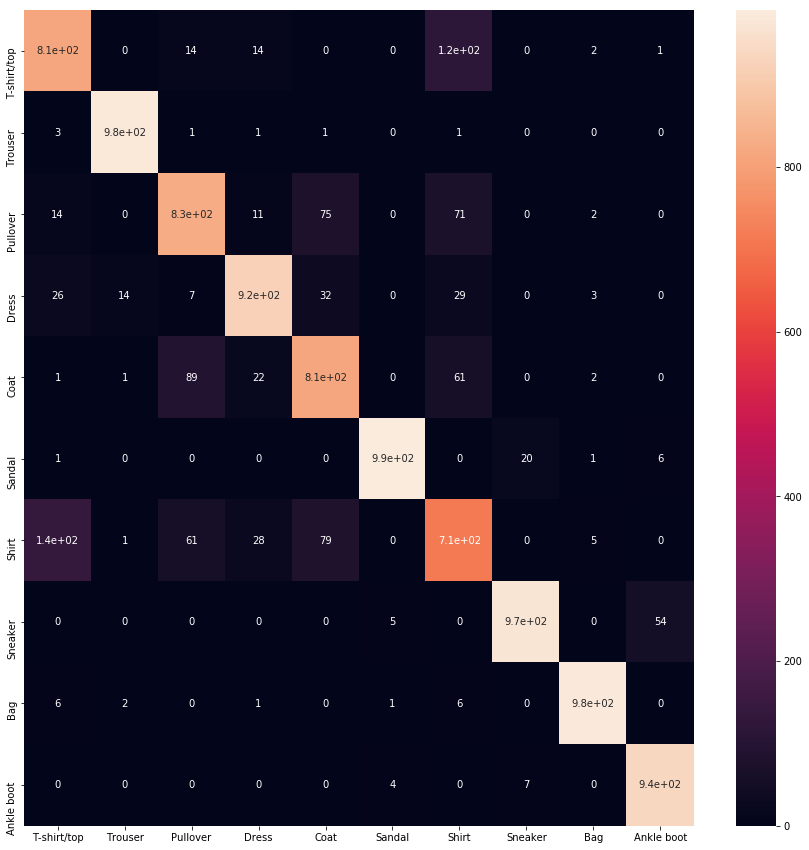

In [18]:
predictions = model.predict(conv_test_data)
cm = confusion_matrix(np.argmax(predictions, axis=1), np.argmax(test_labels, axis=1))
plt.figure(figsize = (15, 15))

sn.heatmap(cm, annot=True, xticklabels=name_labels, yticklabels=name_labels)
plt.show()

90% is pretty respectible, especially considering how speedy training was, and given that we didn't apply any data augmentation. [Some state of the art networks get around 93-95% accuracy](https://github.com/zalandoresearch/fashion-mnist). It's also worth noting that we only really fail on comparing pullovers to coats, and tops to t-shirts.

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 44s 807us/step - loss: 1.2878 - acc: 0.7776 - val_loss: 0.3531 - val_acc: 0.8693
Epoch 2/5
54000/54000 [==============================] - 43s 805us/step - loss: 0.3232 - acc: 0.8802 - val_loss: 0.2970 - val_acc: 0.8917
Epoch 3/5
54000/54000 [==============================] - 43s 803us/step - loss: 0.2763 - acc: 0.8986 - val_loss: 0.2749 - val_acc: 0.8960
Epoch 4/5
54000/54000 [==============================] - 43s 803us/step - loss: 0.2500 - acc: 0.9084 - val_loss: 0.2650 - val_acc: 0.9053
Epoch 5/5
54000/54000 [==============================] - 44s 811us/step - loss: 0.2326 - acc: 0.9139 - val_loss: 0.2601 - val_acc: 0.9057


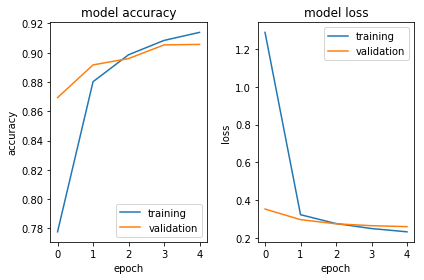

Test loss: 0.28
Test accuracy: 0.902


In [19]:
# One more try... Just for fun. 
model = Sequential()

# Note, fewer filters and a bigger kernel, plus a pooling layer
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Note, more filters and a pooling
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2 dense layers with dropout before the final.
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(conv_training_data, training_labels, batch_size=128, epochs=5, verbose=True, validation_split=.1)

plot_training_history(history, model, eval_images=True)

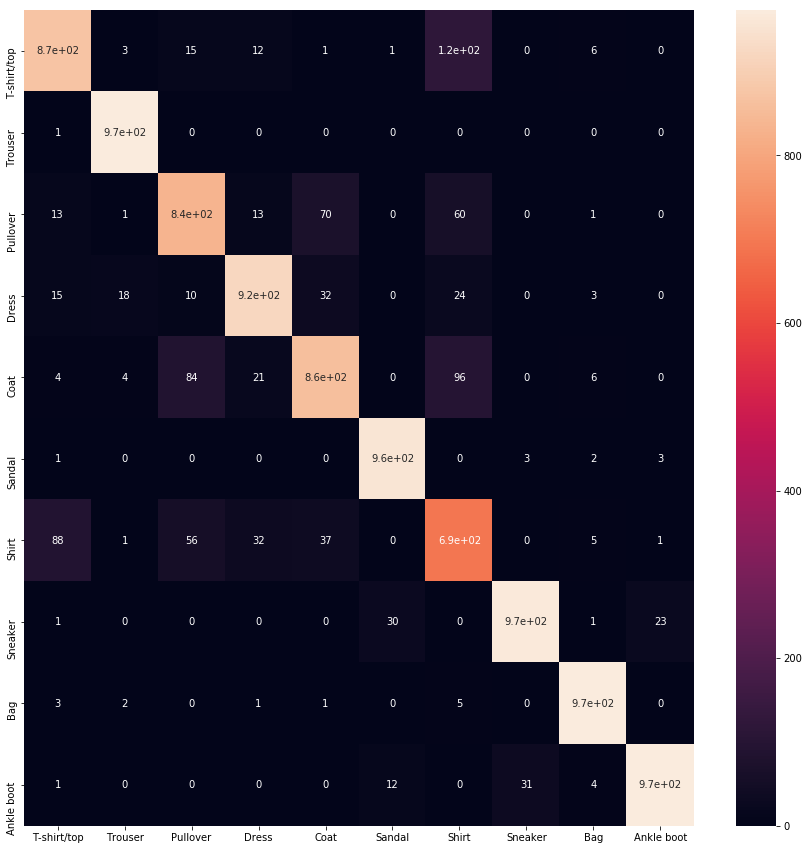

In [20]:
predictions = model.predict(conv_test_data)
cm = confusion_matrix(np.argmax(predictions, axis=1), np.argmax(test_labels, axis=1))
plt.figure(figsize = (15, 15))

sn.heatmap(cm, annot=True, xticklabels=name_labels, yticklabels=name_labels)
plt.show()